In [2]:
TEXT_CLASSIFIER_DATASET1_PATH =  "/content/drive/MyDrive/ariadne_dataset.csv"
TEXT_CLASSIFIER_DATASET2_PATH = "/content/drive/MyDrive/veracookie_dataset.csv"
TEXT_CLASSIFIER_PATH = "/content/drive/MyDrive/lang_clarity_model.joblib"
VECTORIZER_PATH = "/content/drive/MyDrive/vectorizer.joblib"

In [4]:
import re
import pandas as pd
import nltk
import joblib
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
def preprocess_text(text : str) -> str:
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [6]:
def create_model() -> [RandomForestClassifier, TfidfVectorizer]:
    # For pie chart
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))

            return '{:.1f}%\n({v:d})'.format(pct, v = val)

        return my_format

    nltk.download('stopwords')
    nltk.download('wordnet')

    # Load Ariadne dataset
    df1 = pd.read_csv(TEXT_CLASSIFIER_DATASET1_PATH)
    df1['text'] = df1['text'].astype('str')
    df1['rating'] = df1['rating'].astype('str')

    # Load Veracookie dataset
    df2 = pd.read_csv(TEXT_CLASSIFIER_DATASET2_PATH)
    df2['text'] = df2['text'].astype('str')
    df2['rating'] = df2['rating'].astype('str')

    # Combine two datasets
    x = pd.concat([df1['text'], df2['text']])
    y = pd.concat([df1['rating'], df2['rating']])

    # Preprocess texts
    x = x.apply(preprocess_text)

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

    # Visualize data in training and test sets
    fig, (ax1, ax2) = plt.subplots(1,2)

    train_dist = y_train.value_counts()
    ax1.pie(train_dist, labels = train_dist.index, autopct = autopct_format(train_dist))
    ax1.title.set_text("Distribution of data \n in training set")

    test_dist = y_test.value_counts()
    ax2.pie(test_dist, labels = test_dist.index, autopct = autopct_format(test_dist))
    ax2.title.set_text("Distribution of data \n in testing set")

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)

    # Random Forest Model
    rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rf_classifier.fit(x_train_tfidf, y_train)

    # Predictions
    predictions = rf_classifier.predict(x_test_tfidf)

    # Display confusion matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["GOOD", "BAD"])
    disp.plot()
    plt.show()

    # Display classification report
    report = classification_report(y_test, predictions)
    print("Classification Report:\n", report)

    return [rf_classifier, vectorizer]

In [7]:
def save_model(model : RandomForestClassifier, vectorizer : TfidfVectorizer):
    joblib.dump(model, TEXT_CLASSIFIER_PATH)
    joblib.dump(vectorizer, VECTORIZER_PATH)

In [8]:
def eval_model(model_path : str, vectorizer_path : str, test_dir : str):
    # Load model
    nltk.download('stopwords')
    nltk.download('wordnet')
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)

    # Load dataset
    df = pd.read_csv(test_dir)
    df['text'] = df['text'].astype('str')
    df['rating'] = df['rating'].astype('str')

    x = df['text']
    y = df['rating']

    # Preprocess text
    x = x.apply(preprocess_text)

    # TF-IDF Vectorization
    x_tfidf = vectorizer.transform(x)

    # Predictions
    predictions = model.predict(x_tfidf)

    # Display confusion matrix
    cm = confusion_matrix(y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["GOOD", "BAD"])
    disp.plot()
    plt.show()

    # Display classification report
    report = classification_report(y, predictions)
    print("Classification Report:\n", report)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


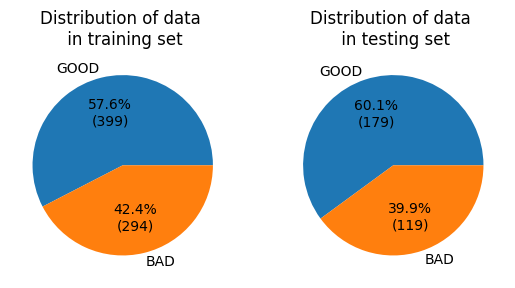

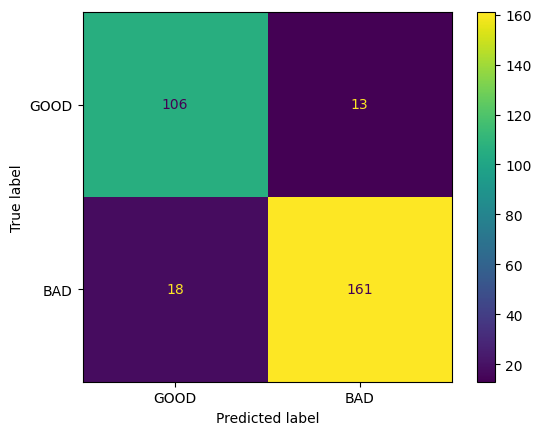

Classification Report:
               precision    recall  f1-score   support

         BAD       0.85      0.89      0.87       119
        GOOD       0.93      0.90      0.91       179

    accuracy                           0.90       298
   macro avg       0.89      0.90      0.89       298
weighted avg       0.90      0.90      0.90       298



In [9]:
model, vectorizer = create_model()

In [10]:
save_model(model, vectorizer)

In [ ]:
# model_path = TEXT_CLASSIFIER_PATH
# vectorizer_path = VECTORIZER_PATH
# test_dir = TEXT_CLASSIFIER_DATASET1_PATH
# eval_model(model_path, vectorizer_path, test_dir)